## Imports and Data Set Up

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import matplotlib
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

data_dir = "./allendata"
df_file = data_dir + "/" + "df.csv"

manifest_path = os.path.join(data_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

def get_dataset(session_number:int, stimulus: str, cortex:str) -> pd.DataFrame:
    session = cache.get_session_data(session_number)
    table = session.get_stimulus_table(stimulus)
    partial_ids = session.units[session.units["ecephys_structure_acronym"] == cortex]

    spike_times_drifting = session.presentationwise_spike_times(
        stimulus_presentation_ids=table.index.values,
        unit_ids=partial_ids.index.values
    )
    return spike_times_drifting.merge(table, left_on="stimulus_presentation_id", right_index=True) \
           .merge(session.units, left_on="unit_id", right_index=True)
           
# df = get_dataset(750332458, "static_gratings", "VISam")
# df.to_csv(df_file)
df = pd.read_csv(df_file)

df.shape

/usr/local/Caskroom/miniconda/base/envs/envallen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(661355, 55)

In [2]:
for col in df.columns:
    print(len(df[col].unique()), col)

656931 spike_time
6000 stimulus_presentation_id
60 unit_id
656931 time_since_stimulus_presentation_onset
3 stimulus_block
6000 start_time
6000 stop_time
2 contrast
6 spatial_frequency
5 phase
1 size
7 orientation
1 stimulus_name
139 duration
121 stimulus_condition_id
60 waveform_PT_ratio
60 waveform_amplitude
60 amplitude_cutoff
60 cluster_id
60 cumulative_drift
60 d_prime
60 firing_rate
54 isi_violations
60 isolation_distance
60 L_ratio
60 local_index
57 max_drift
59 nn_hit_rate
60 nn_miss_rate
30 peak_channel_id
3 presence_ratio
60 waveform_recovery_slope
60 waveform_repolarization_slope
60 silhouette_score
60 snr
9 waveform_spread
27 waveform_velocity_above
34 waveform_velocity_below
29 waveform_duration
1 filtering
30 probe_channel_number
4 probe_horizontal_position
1 probe_id
20 probe_vertical_position
1 structure_acronym
1 ecephys_structure_id
1 ecephys_structure_acronym
1 anterior_posterior_ccf_coordinate
1 dorsal_ventral_ccf_coordinate
1 left_right_ccf_coordinate
1 probe_descri

In [3]:
df_eight = df[(df['spatial_frequency'] == np.float64(0.08)) & (df['phase']==np.float64(0.5))]
df_eight.shape

(35616, 55)

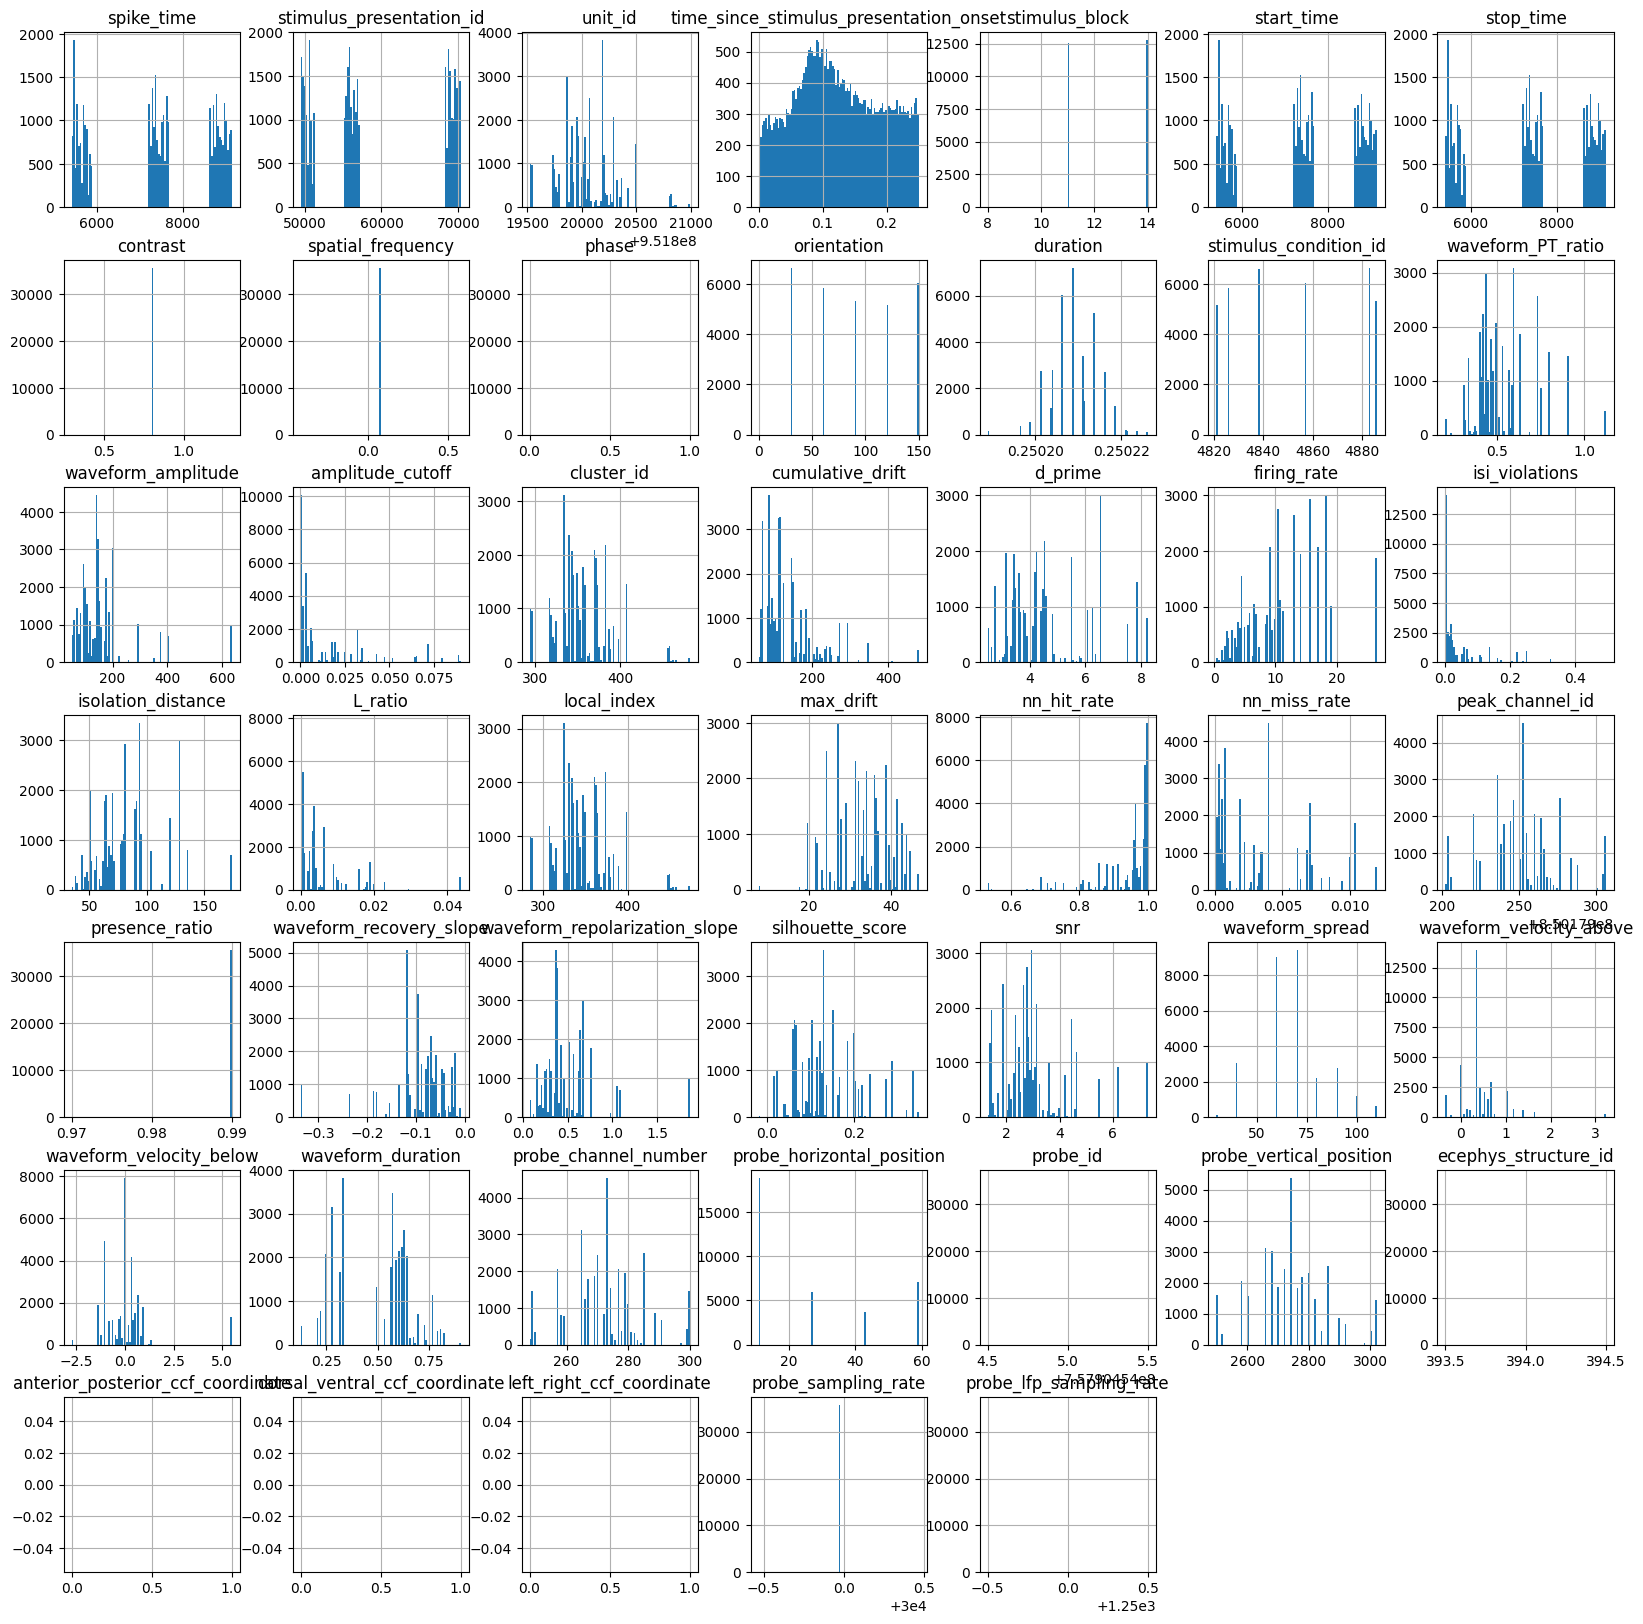

In [4]:
fig = df_eight.hist(figsize=(20,20), bins=100)

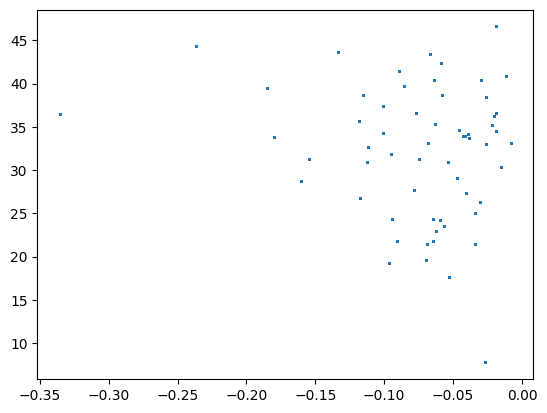

In [5]:
plt.scatter(x=df['waveform_recovery_slope'], y=df['max_drift'], s=0.1)

In [6]:
df_numerical = df_eight.loc[:, ['waveform_recovery_slope', 'max_drift']].drop_duplicates()
df_numerical.shape

(60, 2)

In [8]:
# clustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster

def hierarchical_clustering(df: pd.DataFrame, n_clusters:int =4, method:str ='ward', metric: str='euclidean') -> pd.Series:
    """
    Performs hierarchical clustering on selected columns of a DataFrame.

    Parameters:
    - df: pandas.DataFrame, input data
    - columns: list of str, column names to use for clustering
    - n_clusters: int, the number of clusters to form
    - method: str, linkage method (default: 'ward')
    - metric: str, distance metric (default: 'euclidean')

    Returns:
    - cluster_labels: pandas.Series, cluster label for each row (same index as df)
    """
    X = df.copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    Z = linkage(X_scaled, method=method, metric=metric)
    cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
    return pd.Series(cluster_labels, index=df.index, name='cluster')

clusters = hierarchical_clustering(df_numerical)

df_numerical["clusters"] = clusters
df_numerical.to_csv(data_dir + "/" + "df_numerical.csv")